In [1]:
import numpy as np
import pandas as pd
import pyreadr

data_path = "/data/IDEA_DeFi_Research/Data/AML/LI_Small/preprocessed_user_time/preloaded_4_1000000/checkpoints/testAML/checkpoint-27000/"
# Load embeddings
embeddings = np.load(f"{data_path}cls_embeddings.npy")
embedding_ids = np.load(f"{data_path}cls_embeddings_row_ids.npy")

# Load labels (assuming labels file is available)
labels_df = pyreadr.read_r(f"/data/IDEA_DeFi_Research/Data/AML/LI_Small/y.rds")[None]


In [2]:
labels_df['id'] = labels_df['id'].astype(str)

In [6]:
# Merge embeddings with labels to ensure correct alignment
data_df = pd.DataFrame(embeddings)
data_df["id"] = embedding_ids
merged_data = pd.merge(data_df, labels_df, on="id", how="inner")

# Verify the alignment
print("Merged data shape:", merged_data.shape)
print("Sample merged data:")
print(merged_data.head())


# Now split the embeddings and labels for downstream tasks
X = merged_data.drop(columns=["id", "Is Laundering"]).values
y = merged_data["Is Laundering"].values

# Proceed with downstream tasks (e.g., classification, analysis, etc.)
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")



Merged data shape: (205809, 2146)
Sample merged data:
          0         1         2         3         4         5         6  \
0 -0.337573  1.442493 -1.402154  0.796436 -0.936129  0.647994 -0.360408   
1 -0.363601 -0.585162 -0.038597  0.862857 -0.260762 -0.243423 -0.233859   
2 -0.719967 -0.235205 -0.178085  0.748992 -0.508352 -0.199436 -0.445972   
3 -0.327654  0.072476  0.122439  0.907526  0.035114 -0.501567 -0.852207   
4 -0.740934 -0.181126  0.043537  0.615119 -0.156151 -0.230156 -0.866545   

          7         8         9  ...      2136      2137      2138      2139  \
0 -0.037184 -0.103531 -0.488273  ...  0.336149 -0.796193 -0.608166 -0.165853   
1 -1.295730  0.115021 -0.257923  ...  0.450200 -0.978363  0.435172  0.026135   
2 -0.675585 -0.038811 -0.113864  ...  1.216098 -0.971382  0.845930  0.105089   
3 -0.699691 -0.299245  0.331842  ...  1.419133 -0.617454  0.293403 -0.232871   
4 -0.788064 -0.070229  0.235467  ...  1.309798 -0.902141  0.255453 -0.378393   

       2140   

In [14]:
y

array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
import xgboost as xgb

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)
model.fit(X_train, y_train)


/home/greena12/.conda/envs/greena12/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:53:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     41112
         1.0       0.00      0.00      0.00        50

    accuracy                           1.00     41162
   macro avg       0.50      0.50      0.50     41162
weighted avg       1.00      1.00      1.00     41162

ROC-AUC score: 0.5357


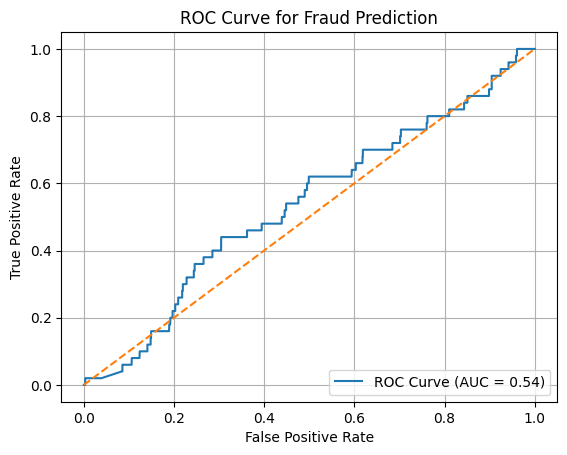

In [12]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification report:")
print(classification_report(y_test, y_pred))

# ROC-AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC score: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fraud Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()